# A Case Study for using the confluence

In [1]:
from data_handler.data_handler import DataHandler
from ta import add_all_ta_features
import analytics.analytics as analytics
import numpy as np

In [2]:
dh = DataHandler()

### Loading the data

In [3]:
COIN = 'BTCUSDT'
data = dh.get_data(COIN, '1d', limit = None).iloc[0:,:] #starting from 1 because the lastest data point's volume isn't the final volume
data = add_all_ta_features(data.reindex(index=data.index[::-1]), open="open", high = "high", low = "low", close = "close", 
                            volume = "volume", fillna = True)
data = data.reindex(index=data.index[::-1])
data = np.round(data[['trend_cci', 'momentum_rsi', 'momentum_kama', 'trend_sma_fast', 'trend_ema_fast', 'trend_macd', 'momentum_ao', 'momentum_uo','close','trend_macd_signal']], 2)

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


### Defining the criterion weights

In [4]:
#[cci, rsi, k_avg, sma, ema, macd, awesome, ultimate]

weights = np.array([0.264526, 0.1568098, 0.10433245, 0.03009723, 0.12768833, 0.21690406, 0.05135256, 0.04828958])

### Calculating the confluence signal

In [5]:
list_weighted_signals = []

for i in range(data.shape[0]-1):
    close = data['close'][i]
    macd_signal = data['trend_macd_signal'][i]
    ao_prev = data['momentum_ao'][i+1]
    values = np.array(np.transpose(data).iloc[:,i])

    signals = analytics.signal_indicator(close, values, macd_signal, ao_prev)

    signals_value = []
    for sig in signals:
        if sig == 'STRONG BUY':
            signals_value.append(0.0)
        elif sig == 'BUY':
            signals_value.append(0.25)
        elif sig == 'NEUTRAL':
            signals_value.append(0.5)
        elif sig == 'SELL':
            signals_value.append(0.75)
        elif sig == 'STRONG SELL':
            signals_value.append(1.0)

    signals_value = np.array(signals_value)
    weighted_signals = weights@signals_value/np.sum(weights)
    list_weighted_signals.append(weighted_signals)
list_weighted_signals = list_weighted_signals[::-1]

In [6]:
import matplotlib.pyplot as plt

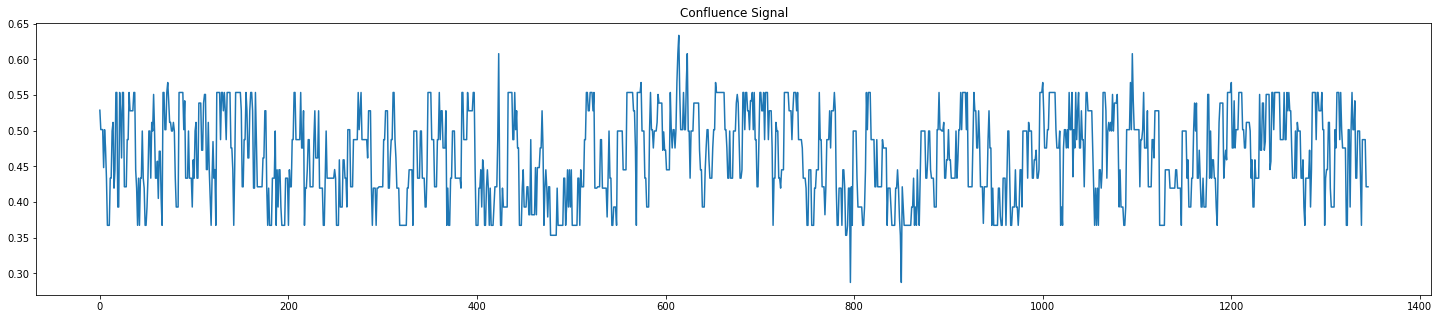

In [7]:
fig = plt.figure(figsize=(25,5))
plt.plot(list_weighted_signals)
plt.title("Confluence Signal")
plt.show()

In [8]:
list_weighted_signals = np.array(list_weighted_signals)

### Buy/Sell Rule

- If the confluence signal is < 0.45: Sell
- If the confluence signal is > 0.55: Buy

In [9]:
a = np.zeros(len(list_weighted_signals))
b = np.zeros(len(list_weighted_signals))

In [10]:
a[list_weighted_signals < 0.45] = 1.0
a[list_weighted_signals > 0.55] = -1.0

In [11]:
buy_index = np.argwhere(a == 1.0)
sell_index = np.argwhere(a == -1.0)

In [12]:
state = 0
state_list = []
for i in range(a.size):
    if a[i] == 1:
        state += 1
    elif a[i] == -1:
        state += -1
        
    if state < 0:
        state = 0
        
    state_list.append(state)
        
state_list = np.array(state_list)

In [13]:
close = data['close'].values[::-1][:-1]
close_next = data['close'].values[::-1][1:]
delta = close_next - close

In [14]:
revenue = delta@state_list
investment = sum(close[buy_index])
coins_value = state_list[-1]*close[-1]
total_value = coins_value+revenue

### 

In [15]:
value = (total_value/investment).item()*100
print(f"Value = {value:.2f}%")

Value = 596.61%


Text(0.5, 1.0, 'Closing Price')

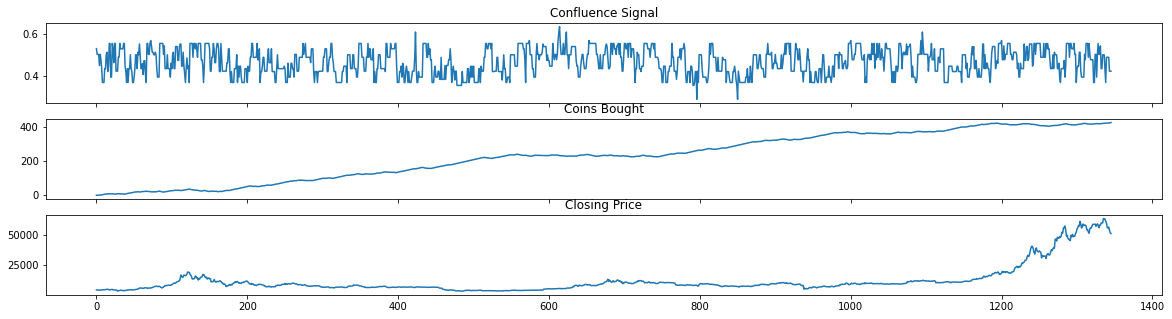

In [16]:
fig, ax = plt.subplots(3,1,figsize=(20,5),sharex=True)
ax[0].plot(list_weighted_signals)
ax[0].set_title("Confluence Signal")
ax[1].plot(state_list)
ax[1].set_title("Coins Bought")
ax[2].plot(close)
ax[2].set_title("Closing Price")
#plt.savefig(f'img/results/{COIN}_{value}.png')